# Wind and foraging interaction

Analysing the wind characteristics of streaked shearwaters as they approach foraging points allows us to examine what conditions the birds travel in throughout foraging trips.

In [1]:
import pandas as pd
import numpy as np
import os, re, glob, pyproj, math, datetime
from sys import platform
import datatable as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import seaborn as sns
import math

## Data

Foraging estimates, as calculated from a recently generated [behaviour acceleration algorithm](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0254454), are read in alongside [wind estimates calculate from seabird GPS tracks](https://www.science.org/doi/10.1126/sciadv.1700097).

In [2]:
# read in data
if platform == "darwin":
    fileloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2018Shearwater/TxtDat/AxyTrek/AlgorithmOutputUpdate/PredictedForage/"
else:
    fileloc = "E:/My Drive/PhD/Data/2018Shearwater/TxtDat/AxyTrek/AlgorithmOutputUpdate/PredictedForage/"

files = glob.glob(fileloc+"*ForageGPS.txt")

forDat = []
for b in files:
    new = pd.read_csv(b)
    new.insert(0,'ID',re.findall('[0-9\-]+',re.search('.*PredictedForage(.+?)_S*',b).group(1)) * len(new))
    forDat.append(new)

for df in forDat:
    df.loc[:,'DT'] = pd.to_datetime(df.loc[:,'DT'],format="%d/%m/%Y %H:%M:%S.%f")
# wind data
if platform == "darwin":
    windloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2018Shearwater/WindEst/MinDat/"
else:
    windloc = "E:/My Drive/PhD/Data/2018Shearwater/WindEst/MinDat/"

wfiles = glob.glob(windloc+"*.csv")
wDat = []
for b in wfiles:
    new = pd.read_csv(b,names=["DT","Lat","Lon","BHead","X","Y"])
    new.insert(0,"ID",re.findall('[0-9\-]+',re.search('.*MinDat(.+?)_S*',b).group(1)) * len(new))
    wDat.append(new)
for df in wDat:
    df.loc[:,'DT'] = pd.to_datetime(df.loc[:,'DT'],format="%Y/%m/%d %H:%M:%S")

## Relative position/time to foraging

For each wind estimation point, the nearest proceeding foraging point is calculated with the distance and time from the next foraging spot calculated.

In [3]:
def DistTimeTo(dt,lat,lon,id,dat):
    try:
        forPoint = np.nanmin(np.where((dat['Forage'] == 1) & (dat['ID'] == id) & (dat['DT'] > dt)))
        tdiff = (dat.loc[forPoint,'DT'] - dt)/np.timedelta64(1,'s')
        azimuth1, azimuth2, distance = pyproj.Geod(ellps='WGS84').inv(dat.loc[forPoint,'Lon'],dat.loc[forPoint,'Lat'],lon,lat)
    except:
        tdiff = float("NaN")
        distance=float("NaN")
    return tdiff,distance/1000
wDatn = []
for tst in wDat:
    ind = []
    for df in forDat:
        if df.loc[1,'ID'] == tst.loc[1,'ID']:
            ind = df
    tmp = [DistTimeTo(tst.loc[b,'DT'],tst.loc[b,'Lat'],tst.loc[b,'Lon'],tst.loc[b,'ID'],ind) for b in range(len(tst))]
    tst.insert(len(tst.columns),'timeTo',[row[0] for row in tmp])
    tst.insert(len(tst.columns),'distTo',[row[1] for row in tmp])

In [4]:
wDat[0]

,ID,DT,Lat,Lon,BHead,X,Y,timeTo,distTo
0,2017-9,2018-09-03 04:19:00,39.46372,142.10781,0.998923,0.230363,-0.251087,245125.0,515.447989
1,2017-9,2018-09-03 04:20:00,39.46852,142.11108,1.006208,0.067269,-0.148363,245065.0,514.851725
2,2017-9,2018-09-03 04:21:00,39.47314,142.11494,1.028696,0.042637,-0.083627,245005.0,514.241635
3,2017-9,2018-09-03 04:22:00,39.47718,142.11913,1.028673,0.042713,-0.083553,244945.0,513.666755
4,2017-9,2018-09-03 04:24:00,39.48570,142.12705,1.024066,-0.166575,0.038019,244825.0,512.500984
...,...,...,...,...,...,...,...,...,...
283,2017-9,2018-09-06 05:14:00,43.05575,145.43083,-1.834442,-4.049100,4.635641,7925.0,47.032203
284,2017-9,2018-09-06 05:15:00,43.05360,145.42589,-1.834910,-4.004563,4.601397,7865.0,46.564683
285,2017-9,2018-09-06 05:20:00,43.04119,145.40137,-1.796466,-4.143610,4.622200,7565.0,44.153806
286,2017-9,2018-09-06 05:21:00,43.03801,145.39805,-1.795401,-4.148359,4.612309,7505.0,43.750272


### Examining binned data

Wind data are binned into groups of 10km distances

In [5]:
for tst in wDat:
    tst['wDir'] = np.arctan2(tst['Y'],tst['X'])
    tst['wSp'] = np.sqrt(tst['X']**2 + tst['Y']**2)
    tst['rwh'] = tst['BHead'] - tst['wDir']
    tst.loc[tst[tst['rwh'] < -np.pi].index,'rwh'] = tst.loc[tst[tst['rwh'] < -np.pi].index,'rwh'] + (2*np.pi)
    tst.loc[tst[tst['rwh'] > np.pi].index,'rwh'] = tst.loc[tst[tst['rwh'] > np.pi].index,'rwh'] - (2*np.pi)
    tst['distGroup'] = pd.cut(tst['distTo'],np.arange(0,np.nanmax(tst['distTo']),10),labels=(np.arange(10,np.nanmax(tst['distTo']),10)))

In [6]:
wDat[0]

,ID,DT,Lat,Lon,BHead,X,Y,timeTo,distTo,wDir,wSp,rwh,distGroup
0,2017-9,2018-09-03 04:19:00,39.46372,142.10781,0.998923,0.230363,-0.251087,245125.0,515.447989,-0.828417,0.340752,1.827340,NaN
1,2017-9,2018-09-03 04:20:00,39.46852,142.11108,1.006208,0.067269,-0.148363,245065.0,514.851725,-1.145113,0.162901,2.151321,NaN
2,2017-9,2018-09-03 04:21:00,39.47314,142.11494,1.028696,0.042637,-0.083627,245005.0,514.241635,-1.099298,0.093869,2.127994,NaN
3,2017-9,2018-09-03 04:22:00,39.47718,142.11913,1.028673,0.042713,-0.083553,244945.0,513.666755,-1.098223,0.093837,2.126896,NaN
4,2017-9,2018-09-03 04:24:00,39.48570,142.12705,1.024066,-0.166575,0.038019,244825.0,512.500984,2.917195,0.170859,-1.893129,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2017-9,2018-09-06 05:14:00,43.05575,145.43083,-1.834442,-4.049100,4.635641,7925.0,47.032203,2.288760,6.155028,2.159983,50.0
284,2017-9,2018-09-06 05:15:00,43.05360,145.42589,-1.834910,-4.004563,4.601397,7865.0,46.564683,2.286954,6.099949,2.161322,50.0
285,2017-9,2018-09-06 05:20:00,43.04119,145.40137,-1.796466,-4.143610,4.622200,7565.0,44.153806,2.301651,6.207595,2.185068,50.0
286,2017-9,2018-09-06 05:21:00,43.03801,145.39805,-1.795401,-4.148359,4.612309,7505.0,43.750272,2.303286,6.203408,2.184499,50.0


Text(0, 0.5, 'Lat')

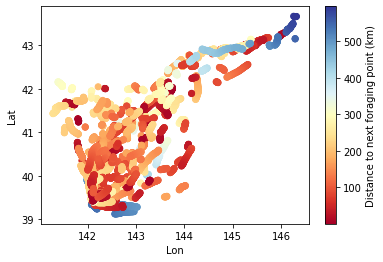

In [7]:
allwDat = pd.concat(wDat)
cm = plt.cm.get_cmap('RdYlBu')
colours = [cm(1.*i/len(allwDat.groupby('distGroup').count())) for i in range(len(allwDat.groupby('distGroup').count()))]
xy = range(len(np.arange(0,np.nanmax(allwDat['distTo']),10)))

plt.scatter(allwDat['Lon'],allwDat['Lat'],c=allwDat['distTo'])
cb = plt.colorbar()
cb.set_label('Distance to next foraging point (km)')
plt.set_cmap(cm)
plt.xlabel('Lon')
plt.ylabel('Lat')

In [8]:
for df in wDat:
    df['aligned'] = df['rwh'] + np.pi
    df.loc[df[df['aligned'] > np.pi].index,'aligned'] = df.loc[df[df['aligned'] > np.pi].index,'aligned'] - 2*np.pi
    df.loc[df[df['aligned'] > np.pi].index,'aligned'] = df.loc[df[df['aligned'] > np.pi].index,'aligned'] - 2*np.pi
    df.loc[df[df['aligned'] < -np.pi].index,'aligned'] = df.loc[df[df['aligned'] < -np.pi].index,'aligned'] + 2*np.pi

# sns.displot(df.loc[df[df['distTo'] < 100].index,:],x='aligned',hue='distGroup')

## Data per individual

Wishing to look at the wind conditions of individuals flying towards foraging spots. This way, we have an idea of how the birds are using winds on approach. So therefore, we can explore the wind data to find how much wind data is available prior to each foraging point.

In [10]:
for tst in wDat:
    for df in forDat:
        if df.loc[1,'ID'] == tst.loc[1,'ID']:
            ind = df
    forPoints = np.where(ind['Forage'] == 1)[0]
    forNo = range(len(forPoints))
    for b in range(len(tst)):
        try:
            tst.loc[b,'forageNo'] = forNo[np.nanmin(np.where(ind.loc[forPoints,'DT'] > tst.loc[b,'DT'])[0])] +1
        except:
            pass

Text(0, 0.5, 'Lat')

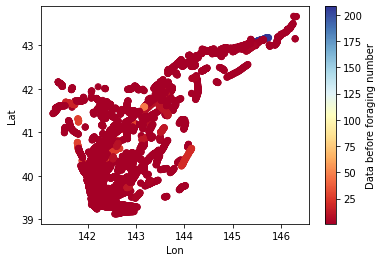

In [13]:
allwDat = pd.concat(wDat)
cm = plt.cm.get_cmap('RdYlBu')
colours = [cm(1.*i/len(allwDat.groupby('forageNo').count())) for i in range(len(allwDat.groupby('forageNo').count()))]
xy = range(len(np.arange(0,np.nanmax(allwDat['distTo']),10)))

plt.scatter(allwDat['Lon'],allwDat['Lat'],c=allwDat['forageNo'])
cb = plt.colorbar()
cb.set_label('Data before foraging number')
plt.set_cmap(cm)
plt.xlabel('Lon')
plt.ylabel('Lat')

Text(0.5, 1.0, 'Wind data available before each foraging')

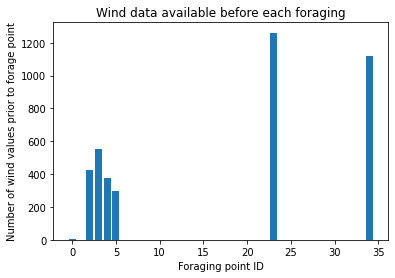

In [7]:
# wind counts for each foraging point within 2 hours of next FP
sub = wDat.loc[wDat[wDat['timeTo'] < 3600*2].index,:]
groups = sub.groupby('forageNo')
forWdat = pd.DataFrame(groups.size())
forWdat['forageNo'] = forWdat.index
plt.bar(forWdat['forageNo'],forWdat[0])
plt.xlabel('Foraging point ID')
plt.ylabel('Number of wind values prior to forage point')
plt.title('Wind data available before each foraging')

If we explore the data for foraging points with the most available wind data, the following data is shown:

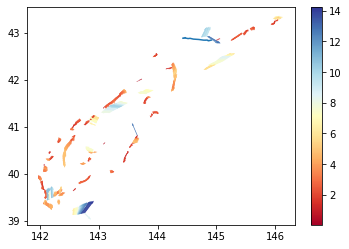

In [183]:
sel=forWdat.loc[forWdat[0].idxmax(),'forageNo']
tst = np.where(sub['forageNo'] == sel)[0][0]

plt.plot(forDat.loc[(forDat['DT'] >= sub.loc[tst,'DT']) & (forDat['DT'] < (sub.loc[tst,'DT']+np.timedelta64(2,'h'))) & (forDat['ID'] == sub.loc[tst,'ID']),'Lon'],
forDat.loc[(forDat['DT'] >= sub.loc[tst,'DT']) & (forDat['DT'] < (sub.loc[tst,'DT']+np.timedelta64(2,'h'))) & (forDat['ID'] == sub.loc[tst,'ID']),'Lat'],zorder=0)
plt.quiver(sub.loc[sub[sub['forageNo'] == sel].index,'Lon'],sub.loc[sub[sub['forageNo'] == sel].index,'Lat'],
sub.loc[sub[sub['forageNo'] == sel].index,'X'],sub.loc[sub[sub['forageNo'] == sel].index,'Y'],
sub.loc[sub[sub['forageNo'] == sel].index,'wSp'])
cb=plt.colorbar()



In [161]:
forDat.loc[(forDat['DT'] >= sub.loc[tst,'DT']) & (forDat['DT'] < (sub.loc[tst,'DT']+np.timedelta64(2,'h'))) & (forDat['ID'] == sub.loc[tst,'ID']),'Lon']

263541    142.36030
263542    142.35811
263543    142.35676
263544    142.35731
263545    142.35527
            ...    
263750    142.36254
263751    142.36289
263752    142.36356
263753    142.36401
263754    142.36441
Name: Lon, Length: 214, dtype: float64

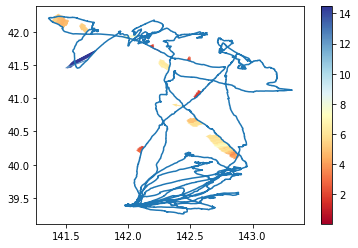

In [174]:
# plt.scatter(sub.loc[sub[sub['forageNo'] == sel].index,"Lon"],sub.loc[sub[sub['forageNo'] == sel].index,"Lat"])
plt.plot(forDat.loc[forDat[forDat['ID'] == '3'].index,'Lon'],forDat.loc[forDat[forDat['ID'] == '3'].index,'Lat'])
plt.quiver(sub.loc[sub[sub['forageNo'] == sel].index,'Lon'],sub.loc[sub[sub['forageNo'] == sel].index,'Lat'],
sub.loc[sub[sub['forageNo'] == sel].index,'X'],sub.loc[sub[sub['forageNo'] == sel].index,'Y'],
sub.loc[sub[sub['forageNo'] == sel].index,'wSp'])
cb=plt.colorbar()


In [158]:
ed

295321

In [ ]:
forWdat['forageNo'] = forWdat.index
plt.bar(forWdat['forageNo'],forWdat[0])
plt.xlabel('Foraging point ID')
plt.ylabel('Number of wind values prior to forage point')
plt.title('Wind data available before each foraging point')

In [66]:
wDat

,ID,DT,Lat,Lon,BHead,X,Y,timeTo,distTo,wDir,rwh,distGroup,forageNo,wSp,aligned
0,1,2018-09-02 04:09:20,39.41675,142.08674,0.838811,-1.804529,-2.990987,374.0,434.079436,-2.113655,2.952467,440.0,0.0,3.493183,-0.189126
1,1,2018-09-02 04:09:35,39.41893,142.08990,0.838831,-1.804457,-2.991062,359.0,433.741293,-2.113626,2.952457,440.0,0.0,3.493210,-0.189135
2,1,2018-09-02 04:10:05,39.42218,142.09146,0.838807,-1.804476,-2.991030,329.0,433.358471,-2.113636,2.952443,440.0,0.0,3.493193,-0.189150
3,1,2018-09-02 04:10:35,39.42554,142.09307,0.838812,-1.804513,-2.990932,299.0,432.962807,-2.113659,2.952472,440.0,0.0,3.493128,-0.189121
4,1,2018-09-02 04:11:07,39.42873,142.09424,0.838798,-1.804610,-2.990921,267.0,432.600975,-2.113685,2.952483,440.0,0.0,3.493169,-0.189110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,2017-9,2018-09-07 00:34:10,43.05575,145.43083,-1.834442,-4.049100,4.635641,NaN,NaN,2.288760,2.159983,NaN,NaN,6.155028,-0.981609
9724,2017-9,2018-09-07 00:34:41,43.05360,145.42589,-1.834910,-4.004563,4.601397,NaN,NaN,2.286954,2.161322,NaN,NaN,6.099949,-0.980271
9725,2017-9,2018-09-07 00:35:11,43.04119,145.40137,-1.796466,-4.143610,4.622200,NaN,NaN,2.301651,2.185068,NaN,NaN,6.207595,-0.956525
9726,2017-9,2018-09-07 00:35:41,43.03801,145.39805,-1.795401,-4.148359,4.612309,NaN,NaN,2.303286,2.184499,NaN,NaN,6.203408,-0.957093
